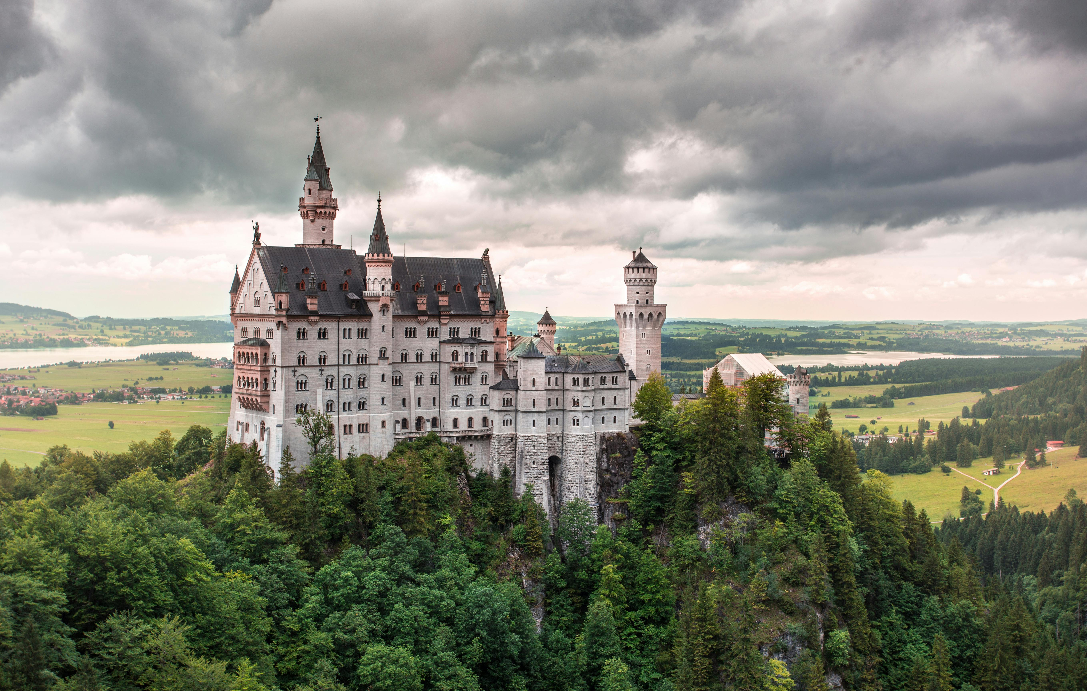

In [43]:
# importing & loading libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread("castle.jpg")
image = cv2.resize(image, None, fx=0.2, fy=0.2)
cv2_imshow(image)

In [61]:
# storing everything related to energy
class ImageEnergy:
  def __init__(self, image: np.ndarray):
    self.__energy = np.zeros(image.shape[:2], dtype=np.float64)
    for channel in range(3):
      sobel_x = cv2.Sobel(image[:, :, channel], cv2.CV_64F, 1, 0, ksize = 3)
      sobel_y = cv2.Sobel(image[:, :, channel], cv2.CV_64F, 0, 1, ksize = 3)
      self.__energy += np.abs(sobel_x) + np.abs(sobel_y)

  def get(self, x: int, y: int) -> float:
    return self.__energy[y, x]

  def matrix(self) -> np.ndarray:
    return self.__energy

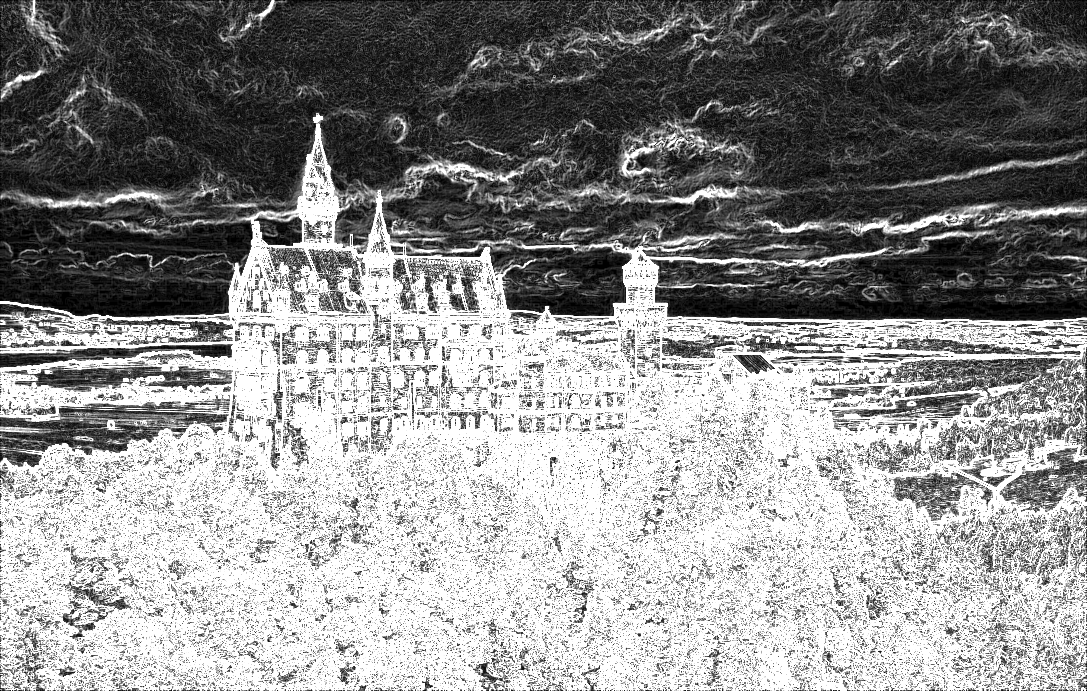

In [62]:
# testing the class defined earlier
energy = ImageEnergy(image)
cv2_imshow(energy.matrix())

In [95]:
def remove_vertical_seam(img: np.ndarray, seam_x: np.ndarray) -> np.ndarray:
    """return a copy of img with one vertical seam removed (per-row x)"""
    h, w = img.shape[:2]
    if w <= 1:
        raise ValueError("cannot remove vertical seam from width=1 image")
    if img.ndim == 2:
        out = np.empty((h, w-1), dtype=img.dtype)
        for y in range(h):
            x = seam_x[y]
            out[y, :x] = img[y, :x]
            out[y, x:] = img[y, x+1:]
        return out
    else:
        c = img.shape[2]
        out = np.empty((h, w-1, c), dtype=img.dtype)
        for y in range(h):
            x = seam_x[y]
            out[y, :x, :] = img[y, :x, :]
            out[y, x:, :] = img[y, x+1:, :]
        return out

def remove_horizontal_seam(img: np.ndarray, seam_y: np.ndarray) -> np.ndarray:
    """return a copy of img with one horizontal seam removed (per-column y)"""
    h, w = img.shape[:2]
    if h <= 1:
        raise ValueError("cannot remove horizontal seam from height=1 image")
    if img.ndim == 2:
        out = np.empty((h-1, w), dtype=img.dtype)
        for x in range(w):
            y = seam_y[x]
            out[:y, x] = img[:y, x]
            out[y:, x] = img[y+1:, x]
        return out
    else:
        c = img.shape[2]
        out = np.empty((h-1, w, c), dtype=img.dtype)
        for x in range(w):
            y = seam_y[x]
            out[:y, x, :] = img[:y, x, :]
            out[y:, x, :] = img[y+1:, x, :]
        return out

In [96]:
def dp_vertical(energy: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    vertical seams (top→bottom)
    returns (cumulative_costs, steps)
    steps[y, x] ∈ {-1, 0, +1} = delta-x from row y-1 to y
    """
    energy = energy.astype(np.float64, copy=False)
    h, w = energy.shape
    M = energy.copy()
    steps = np.zeros((h, w), dtype=np.int8)

    # first row already equals energy[0, :]
    for y in range(1, h):
        for x in range(w):
            best_cost = M[y-1, x]
            best_step = 0
            if x > 0 and M[y-1, x-1] < best_cost:
                best_cost = M[y-1, x-1]
                best_step = -1
            if x < w-1 and M[y-1, x+1] < best_cost:
                best_cost = M[y-1, x+1]
                best_step = +1
            M[y, x] += best_cost
            steps[y, x] = best_step

    return M, steps


def dp_horizontal(energy: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    horizontal seams (left→right)
    returns (cumulative_costs, steps)
    steps[y, x] ∈ {-1, 0, +1} = delta-y from column x-1 to x
    """
    energy = energy.astype(np.float64, copy=False)
    h, w = energy.shape
    M = energy.copy()
    steps = np.zeros((h, w), dtype=np.int8)

    # first column already equals energy[:, 0]
    for x in range(1, w):
        for y in range(h):
            best_cost = M[y, x-1]
            best_step = 0
            if y > 0 and M[y-1, x-1] < best_cost:
                best_cost = M[y-1, x-1]
                best_step = -1
            if y < h-1 and M[y+1, x-1] < best_cost:
                best_cost = M[y+1, x-1]
                best_step = +1
            M[y, x] += best_cost
            steps[y, x] = best_step

    return M, steps

In [101]:
# provides the implementation of the seam carving resizer using dp
class SeamCarving:
  def __init__(self, image):
    self.__image = image
    self.__energy = ImageEnergy(image)
    E = self.__energy.matrix()  # 2D (h, w) float

    self.__vertical, self.__vertical_steps = dp_vertical(E)
    self.__horizontal, self.__horizontal_steps = dp_horizontal(E)

  def _trace_min_vertical_seam(self) -> np.ndarray:
    """return x of the seam per row"""
    seam_dp = self.__vertical
    steps = self.__vertical_steps
    h, w = seam_dp.shape
    x = int(np.argmin(seam_dp[-1, :]))
    seam_x = np.empty(h, dtype=np.int32)
    seam_x[-1] = x
    for y in range(h-2, -1, -1):
        x = x + int(steps[y+1, x])
        seam_x[y] = x
    return seam_x

  def show_vertical(self, color=(255, 0, 0), thickness=1) -> np.ndarray:
    img = self.__image.copy()
    h, _ = self.__vertical.shape
    seam_x = self._trace_min_vertical_seam()

    for y in range(h):
        x = int(seam_x[y])
        x0 = max(0, x - thickness // 2)
        x1 = min(img.shape[1], x0 + thickness)
        img[y, x0:x1] = color  # paint pixels
    return img

  def _trace_min_horizontal_seam(self) -> np.ndarray:
      """return y of the seam per row"""
      seam_dp = self.__horizontal
      steps = self.__horizontal_steps
      h, w = seam_dp.shape
      y = int(np.argmin(seam_dp[:, -1]))
      seam_y = np.empty(w, dtype=np.int32)
      seam_y[-1] = y
      for x in range(w-2, -1, -1):
          y = y + int(steps[y, x+1])
          seam_y[x] = y
      return seam_y

  def show_horizontal(self, color=(255, 0, 0), thickness=1) -> np.ndarray:
    img = self.__image.copy()
    _, w = self.__horizontal.shape
    seam_y = self._trace_min_horizontal_seam()

    for x in range(w):
        y = int(seam_y[x])
        y0 = max(0, y - thickness // 2)
        y1 = min(img.shape[0], y0 + thickness)
        img[y0:y1, x] = color
    return img

  def show_horizontal(self, color=(255, 0, 0), thickness=1) -> np.ndarray:
    img = self.__image.copy()
    _, w = self.__horizontal.shape
    seam_y = self._trace_min_horizontal_seam()
    for x in range(w):
        y = int(seam_y[x])
        y0 = max(0, y - thickness // 2)
        y1 = min(img.shape[0], y0 + thickness)
        img[y0:y1, x] = color
    return img

  def _recompute(self):
    """recompute energy + DP tables from current image"""
    self.__energy = ImageEnergy(self.__image)
    E = self.__energy.matrix()
    self.__vertical, self.__vertical_steps = dp_vertical(E)
    self.__horizontal, self.__horizontal_steps = dp_horizontal(E)

  def pop_vertical(self) -> np.ndarray:
    """remove the minimal vertical seam; returns the updated image"""
    seam_x = self._trace_min_vertical_seam()
    self.__image = remove_vertical_seam(self.__image, seam_x)
    self._recompute()
    return self.__image

  def pop_horizontal(self) -> np.ndarray:
    """remove the minimal horizontal seam; returns the updated image"""
    seam_y = self._trace_min_horizontal_seam()
    self.__image = remove_horizontal_seam(self.__image, seam_y)
    self._recompute()
    return self.__image

  def shrink(self, target_width: int, target_height: int) -> np.ndarray:
    """
    carve seams until the image reaches (target_width, target_height)
    only shrinking is supported here
    returns the new image
    """
    h, w = self.__image.shape[:2]
    if target_width > w or target_height > h:
        raise ValueError("shrink() only supports reducing size")
    if target_width <= 0 or target_height <= 0:
        raise ValueError("invalid target size")

    need_v = w - target_width      # vertical seams to remove
    need_h = h - target_height     # horizontal seams to remove
    if need_v == 0 and need_h == 0:
        return self.__image

    # interleave removals to limit distortion (Bresenham-like scheduler)
    # greedy demo implementation
    removed_v = removed_h = 0
    total = need_v + need_h
    for i in range(total):
        # decide which seam to remove next to match the ratio need_v:need_h
        # remove vertical if vertical progress is behind its quota
        if need_v > 0 and (need_h == 0 or (removed_v * need_h) <= (removed_h * need_v)):
            self.pop_vertical()
            removed_v += 1
        else:
            self.pop_horizontal()
            removed_h += 1

    return self.__image

In [104]:
image.shape

(691, 1087, 3)

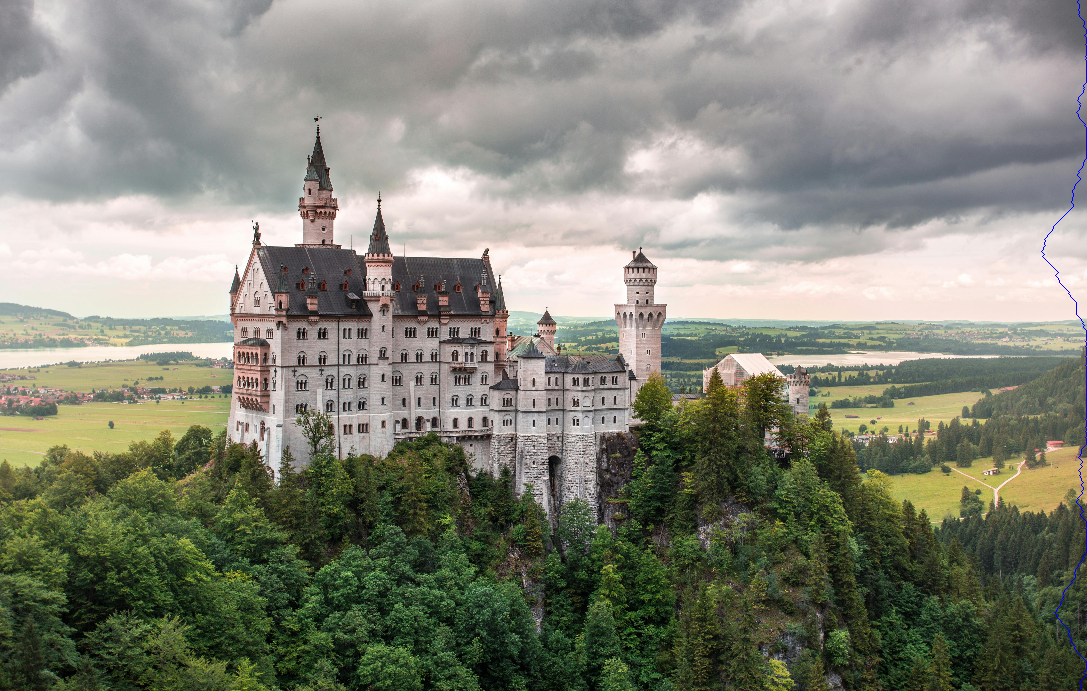

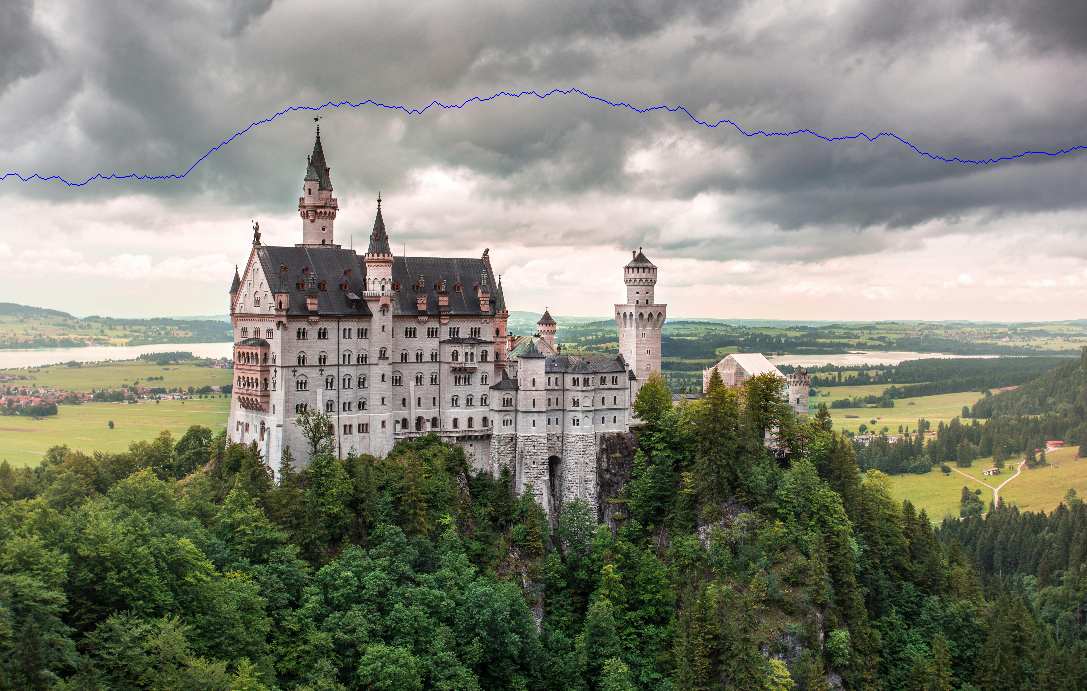

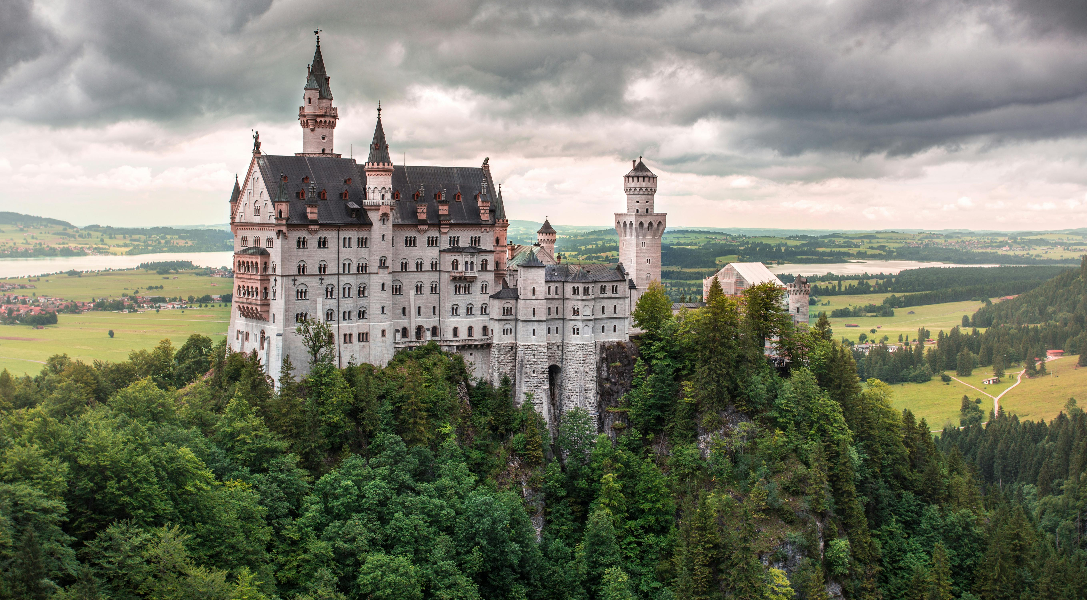

In [110]:
# testing the seam carving class
alg = SeamCarving(image)
cv2_imshow(alg.show_vertical())
cv2_imshow(alg.show_horizontal())
cv2_imshow(alg.shrink(1087, 600))